This notebook demonstrates the simple usage of pretrained foundation model backbones on an image retrieval task. It includes:
- Load a classification dataset
- Load a pretrained foundation model as encoder
- Image embedding generation
- Similarity search
- Evaluation based on image labels
- Inference on some samples



In [1]:
# install dependencies
!pip install -q torchgeo # for dataset and some supported models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
# import basic libraries
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import numpy as np
from typing import Tuple, List, Dict, Any

# check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load dataset

We use the CopernicusBench-EuroSAT-S2 dataset for example. This dataset is a classification dataset based on Sentinel-2 images (13 bands, 10m resolution, 64x64 pixels), each image falling into 1 of 10 land use land cover classes.

In [64]:
from torchgeo.datasets import CopernicusBenchEuroSATS2, CopernicusBenchEuroSATS1
import kornia as K

mean_s2 = [1353.7,1117.2,1041.8,946.5,1199.1,2003.0,2374.0,2301.2,2599.7,732.1,12.1,1820.6,1118.2]
std_s2 = [897.3,736.0,684.8,620.0,791.9,1341.3,1595.4,1545.5,1750.1,475.1,98.3,1216.5,736.7]
mean_s1 = [-12.548, -20.192]
std_s1 = [5.257, 5.912]

transforms_s2 = K.augmentation.AugmentationSequential(
  K.augmentation.Resize(size=(64,64), align_corners=True),
  K.augmentation.Normalize(mean=mean_s2, std=std_s2),
  data_keys=None,
  keepdim=True,
)
transforms_s1 = K.augmentation.AugmentationSequential(
  K.augmentation.Resize(size=(64,64), align_corners=True),
  K.augmentation.Normalize(mean=mean_s1, std=std_s1),
  data_keys=None,
  keepdim=True,
)

# Load the dataset as a Pytorch Dataset
# trainset as gallery, val/test set as query
dataset_train = CopernicusBenchEuroSATS2(root='data', split='train', bands=None, transforms=transforms_s2, download=True, checksum=False)
dataset_val = CopernicusBenchEuroSATS2(root='data', split='val', bands=None, transforms=transforms_s2, download=True, checksum=False)
dataset_test = CopernicusBenchEuroSATS2(root='data', split='test', bands=None, transforms=transforms_s2, download=True, checksum=False)

# (advanced) s2 as gallery, s1 as query
#dataset_test = CopernicusBenchEuroSATS1(root='data', split='test', bands=None, transforms=transforms_s1, download=True, checksum=False)

dict_keys(['image', 'label', 'lat', 'lon'])
torch.Size([13, 64, 64]) tensor(3) tensor(38.0040) tensor(-0.9759)


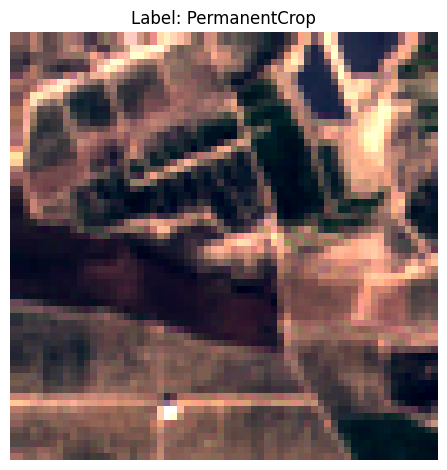

In [4]:
# check and visualize some data
sample = dataset_train[3]
print(sample.keys())
print(sample['image'].shape, sample['label'], sample['lat'], sample['lon'])

dataset_train.plot(sample).show()

In [65]:
# create dataloader
dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, drop_last=False, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=2, drop_last=False, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=16, num_workers=2, drop_last=False, shuffle=False)

## Load pretrained foundation model
In this demo, we choose [Copernicus-FM](https://github.com/zhu-xlab/Copernicus-FM/tree/main/Copernicus-FM) as the pretrained foundation model.

In [6]:
from torchgeo.models import copernicusfm_base,CopernicusFM_Base_Weights
encoder = copernicusfm_base(weights=CopernicusFM_Base_Weights.CopernicusFM_ViT)

Downloading: "https://huggingface.co/torchgeo/copernicus-fm/resolve/f395812cc990ba25a451dbb9c9e6d95c8482947e/CopernicusFM_ViT_base_varlang-085350e4.pth" to /root/.cache/torch/hub/checkpoints/CopernicusFM_ViT_base_varlang-085350e4.pth


100%|██████████| 532M/532M [00:02<00:00, 203MB/s]


In [7]:
print(encoder)

CopernicusFM(
  (fc_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (patch_embed_spectral): DynamicPatchEmbed(
    (spectrum_central_expansion): FourierExpansion()
    (spectrum_bandwidth_expansion): FourierExpansion()
    (weight_generator): TransformerWeightGenerator(
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=2048, bias=True)
            (dropout): Dropout(p=False, inplace=False)
            (linear2): Linear(in_features=2048, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=False, inplace=False)
            (drop

## Feature Extraction (Gallery & Query)
Extract feature embeddings for all images in gallery and query.

In [53]:
## For Copernicus-FM that is flexible for different modalities, we need additional metadata input to guide the model. Check source repo or torchgeo documentation for details.

# spectral response for Sentinel-2 TOA, they serve as input to generate modality-suitable patch embedding
wavelengths_s2 = [440, 490, 560, 665, 705, 740, 783, 842, 860, 940, 1370, 1610, 2190]
bandwidths_s2 = [20, 65, 35, 30, 15, 15, 20, 115, 20, 20, 30, 90, 180]
wavelengths_s1 = [50000000, 50000000]
bandwidths_s1 = [1e9, 1e9]
# time metadata and hyperparameter
start = datetime(1970, 1, 1)
kernel_size = 16

In [54]:
# extract feature embeddings
def extract_features(dl, modality):
  if modality=='s1':
    wavelengths = wavelengths_s1
    bandwidths = bandwidths_s1
  if modality=='s2':
    wavelengths = wavelengths_s2
    bandwidths = bandwidths_s2
  encoder.eval()
  encoder.to(device)
  embs, labels, paths = [], [], []
  for batch in tqdm(dl, desc="Extracting"):
    # image and ground truth
    x = batch['image'].to(device)        # [B, 13, 128, 128]
    y = batch['label'].to(device)        # [B, ]
    # meta data
    lon = batch['lon']
    lat = batch['lat']
    time = torch.full_like(lon, torch.nan) # time is not available in this dataset
    area = (16*10/1000)**2 # surface area of one patch
    area = torch.full((x.shape[0],), area)
    meta_data = torch.stack((lon,lat,time,area),dim=-1).to(device)
    with torch.no_grad():
      feats = encoder(x, meta_data, wavelengths, bandwidths, language_embed=None, input_mode='spectral', kernel_size=kernel_size) # [B,768]
    embs.append(feats.cpu())
    labels.append(y.clone())

  paths = [p for p in dl.dataset.files]
  return {
    "embs": torch.cat(embs, dim=0),   # [N, D]
    "labels": torch.cat(labels, dim=0),  # [N]
    "paths": paths,
  }

In [66]:
#gallery = extract_features(dataloader_train, modality='s2')
query = extract_features(dataloader_test, modality='s2')
#query = extract_features(dataloader_test, modality='s1')

def l2_normalize(x: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    return x / (x.norm(dim=-1, keepdim=True) + eps)

G = l2_normalize(gallery["embs"])  # [Ng, D]
Q = l2_normalize(query["embs"])    # [Nq, D]

Ng, Nq, D = G.size(0), Q.size(0), G.size(1)
print(f"[Feat] Gallery: {Ng} x {D}, Query: {Nq} x {D}")

Extracting: 100%|██████████| 338/338 [00:36<00:00,  9.14it/s]


[Feat] Gallery: 16200 x 768, Query: 5400 x 768


## Similarity search
Search top-k similar images for each image in the query.

In [67]:
def cosine_similarity_matrix(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    # A: [Nq, D], B: [Ng, D] -> [Nq, Ng]
    return A @ B.t()

@torch.no_grad()
def topk_search(Q: torch.Tensor, G: torch.Tensor, k:int=10) -> Tuple[torch.Tensor, torch.Tensor]:
    sims = cosine_similarity_matrix(Q, G)           # [Nq, Ng]
    vals, idxs = torch.topk(sims, k=min(k, G.size(0)), dim=1)  # [Nq, k]
    return vals.cpu(), idxs.cpu()

TOPK = 10
sims_k, idxs_k = topk_search(Q, G, k=TOPK)
print("[Search] Done")
print(sims_k.shape, idxs_k.shape)


[Search] Done
torch.Size([5400, 10]) torch.Size([5400, 10])


## Evaluate
Evaluate the retrieval performance with multiple quantitative matrics: Recall@K, Precision@K, mAP@K, nDCG@K

In [60]:

def relevance_matrix(idxs_k: torch.Tensor, query_labels: torch.Tensor, gallery_labels: torch.Tensor) -> torch.Tensor:
    # idxs_k: [Nq, k] indices into gallery
    # return: rels [Nq, k] with 1 if same class else 0
    rels = []
    gl = gallery_labels.numpy()
    ql = query_labels.numpy()
    for i in range(idxs_k.size(0)):
        rel = (gl[idxs_k[i].numpy()] == ql[i]).astype(np.int32)
        rels.append(rel)
    return torch.tensor(np.stack(rels, axis=0), dtype=torch.float32)

def recall_at_k(rels: torch.Tensor, k:int) -> float:
    # True if at least one positive within top-k
    rel_k = rels[:, :k]
    hit = (rel_k.sum(dim=1) > 0).float().mean().item()
    return hit

def precision_at_k(rels: torch.Tensor, k:int) -> float:
    rel_k = rels[:, :k]
    prec = (rel_k.sum(dim=1) / k).mean().item()
    return prec

def average_precision(rels_row: np.ndarray) -> float:
    # AP for a single query, rels_row: [k] binary
    cum_rel = 0
    prec_sum = 0.0
    for i, r in enumerate(rels_row, start=1):
        if r > 0:
            cum_rel += 1
            prec_sum += cum_rel / i
    return 0.0 if cum_rel == 0 else prec_sum / cum_rel

def mean_average_precision_at_k(rels: torch.Tensor, k:int) -> float:
    arr = rels[:, :k].numpy()
    ap_list = [average_precision(row) for row in arr]
    return float(np.mean(ap_list))

def dcg_at_k(rels_row: np.ndarray, k:int) -> float:
    # graded relevance, here binary -> gains are 1/0; log2 discount
    rels_k = rels_row[:k]
    return float(np.sum([rel / np.log2(i+2) for i, rel in enumerate(rels_k)]))

def ndcg_at_k(rels: torch.Tensor, k:int) -> float:
    arr = rels.numpy()
    scores = []
    for row in arr:
        dcg = dcg_at_k(row, k)
        ideal = np.sort(row)[::-1]  # best ranking
        idcg = dcg_at_k(ideal, k)
        scores.append(0.0 if idcg == 0 else dcg / idcg)
    return float(np.mean(scores))


In [68]:
# Build relevance matrix (same-class = relevant)
rels = relevance_matrix(idxs_k, query["labels"].cpu(), gallery["labels"].cpu())

for K in [1, 5, 10]:
    r = recall_at_k(rels, K)
    p = precision_at_k(rels, K)
    m = mean_average_precision_at_k(rels, K)
    n = ndcg_at_k(rels, K)
    print(f"K={K:>2} | Recall@K={r:.4f}  Precision@K={p:.4f}  mAP@K={m:.4f}  nDCG@K={n:.4f}")

K= 1 | Recall@K=0.7954  Precision@K=0.7954  mAP@K=0.7954  nDCG@K=0.7954
K= 5 | Recall@K=0.9272  Precision@K=0.7372  mAP@K=0.8260  nDCG@K=0.7867
K=10 | Recall@K=0.9565  Precision@K=0.7058  mAP@K=0.8015  nDCG@K=0.8627


## Inference
Given a query image, search top-k similar images in gallery.

In [35]:
encoder.eval()
sample = dataset_test[3]
x = sample['image'].unsqueeze(0).to(device)
lon = sample['lon'].unsqueeze(0).to(device)
lat = sample['lat'].unsqueeze(0).to(device)
time = torch.full_like(lon, torch.nan)
area = (16*10/1000)**2
area = torch.full((x.shape[0],), area).to(device)
meta_data = torch.stack((lon,lat,time,area),dim=-1)
wavelengths = wavelengths_s2
bandwidths = bandwidths_s2


with torch.no_grad():
  embedding = encoder(x, meta_data, wavelengths, bandwidths, language_embed=None, input_mode='spectral', kernel_size=kernel_size)

Q = l2_normalize(embedding.cpu())    # [1,D]
TOPK = 3
sims_k, idxs_k = topk_search(Q, G, k=TOPK) # [1,k]

query image
Top-1 retrieval
Top-2 retrieval
Top-3 retrieval


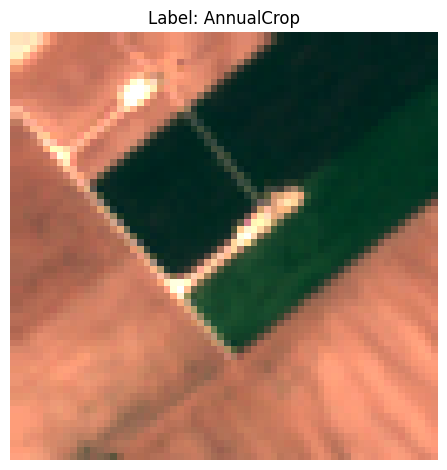

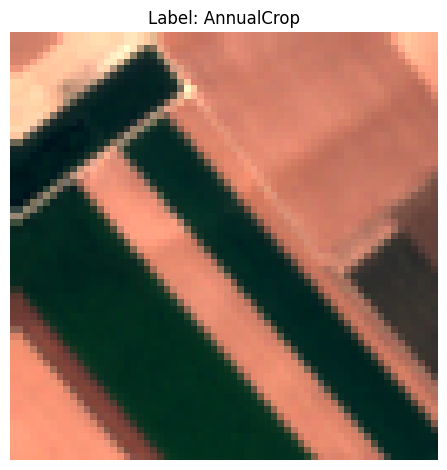

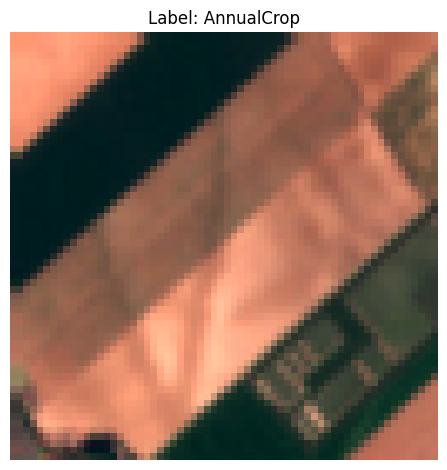

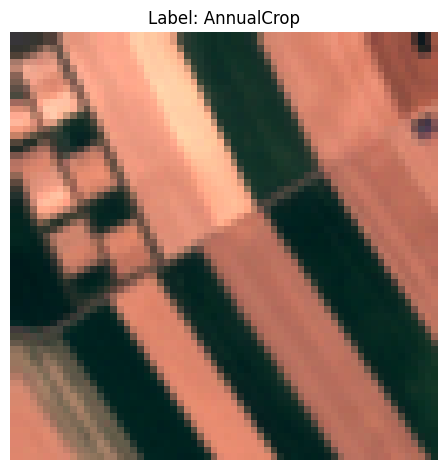

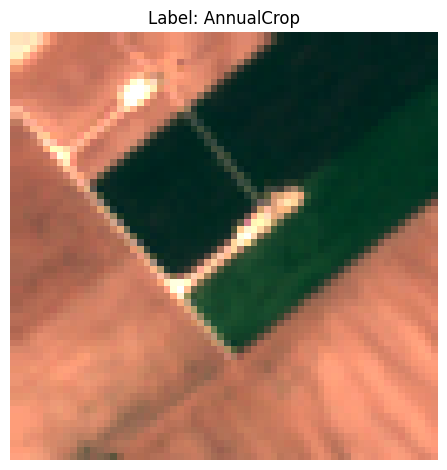

In [46]:
# Visualization
print("query image")
dataset_train.plot(sample)
print("Top-1 retrieval")
dataset_train.plot(dataset_train[idxs_k[0][0].numpy()])
print("Top-2 retrieval")
dataset_train.plot(dataset_train[idxs_k[0][1].numpy()])
print("Top-3 retrieval")
dataset_train.plot(dataset_train[idxs_k[0][2].numpy()])